In [7]:
%matplotlib inline


Gradient descent
==================

An example demoing gradient descent by creating figures that trace the
evolution of the optimizer.



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import sys, os
sys.path.append(os.path.abspath('helper'))
# from cost_functions import mk_quad, mk_gauss, rosenbrock,\
#     rosenbrock_prime, rosenbrock_hessian, LoggingFunction,\
#     CountingFunction

x_min, x_max = -1, 2
y_min, y_max = 2.25/3*x_min - .2, 2.25/3*x_max - .2

In [16]:
def gaussian(x):
    return np.exp(-np.sum(x**2))


def gaussian_prime(x):
    return -2*x*np.exp(-np.sum(x**2))


def gaussian_prime_prime(x):
    return -2*np.exp(-x**2) + 4*x**2*np.exp(-x**2)


def mk_gauss(epsilon, ndim=2):
    def f(x):
        x = np.asarray(x)
        y = x.copy()
        y *= np.power(epsilon, np.arange(ndim))
        return -gaussian(.5*y) + 1

    def f_prime(x):
        x = np.asarray(x)
        y = x.copy()
        scaling = np.power(epsilon, np.arange(ndim))
        y *= scaling
        return -.5*scaling*gaussian_prime(.5*y)

    def hessian(x):
        epsilon = .07
        x = np.asarray(x)
        y = x.copy()
        scaling = np.power(epsilon, np.arange(ndim))
        y *= .5*scaling
        H = -.25*np.ones((ndim, ndim))*gaussian(y)
        d = 4*y*y[:, np.newaxis]
        d.flat[::ndim+1] += -2
        H *= d
        return H

    return f, f_prime, hessian

###############################################################################
# Quadratic functions with varying conditionning

def mk_quad(epsilon, ndim=2):
    def f(x):
       x = np.asarray(x)
       y = x.copy()
       y *= np.power(epsilon, np.arange(ndim))
       return .33*np.sum(y**2)

    def f_prime(x):
       x = np.asarray(x)
       y = x.copy()
       scaling = np.power(epsilon, np.arange(ndim))
       y *= scaling
       return .33*2*scaling*y

    def hessian(x):
       scaling = np.power(epsilon, np.arange(ndim))
       return .33*2*np.diag(scaling)

    return f, f_prime, hessian


###############################################################################
# Super ill-conditionned problem: the Rosenbrock function

def rosenbrock(x):
    y = 4*x
    y[0] += 1
    y[1:] += 3
    return np.sum(.5*(1 - y[:-1])**2 + (y[1:] - y[:-1]**2)**2)


def rosenbrock_prime(x):
    y = 4*x
    y[0] += 1
    y[1:] += 3
    xm = y[1:-1]
    xm_m1 = y[:-2]
    xm_p1 = y[2:]
    der = np.zeros_like(y)
    der[1:-1] = 2*(xm - xm_m1**2) - 4*(xm_p1 - xm**2)*xm - .5*2*(1 - xm)
    der[0] = -4*y[0]*(y[1] - y[0]**2) - .5*2*(1 - y[0])
    der[-1] = 2*(y[-1] - y[-2]**2)
    return 4*der


def rosenbrock_hessian_(x):
    x, y = x
    x = 4*x + 1
    y = 4*y + 3
    return 4*4*np.array((
                    (1 - 4*y + 12*x**2, -4*x),
                    (             -4*x,    2),
                   ))


def rosenbrock_hessian(x):
    y = 4*x
    y[0] += 1
    y[1:] += 3

    H = np.diag(-4*y[:-1], 1) - np.diag(4*y[:-1], -1)
    diagonal = np.zeros_like(y)
    diagonal[0] = 12*y[0]**2 - 4*y[1] + 2*.5
    diagonal[-1] = 2
    diagonal[1:-1] = 3 + 12*y[1:-1]**2 - 4*y[2:]*.5
    H = H + np.diag(diagonal)
    return 4*4*H


###############################################################################
# Helpers to wrap the functions

class LoggingFunction(object):

    def __init__(self, function, counter=None):
        self.function = function
        if counter is None:
            counter = list()
        self.counter = counter
        self.all_x_i = list()
        self.all_y_i = list()
        self.all_f_i = list()
        self.counts = list()

    def __call__(self, x0):
        x_i, y_i = x0[:2]
        self.all_x_i.append(x_i)
        self.all_y_i.append(y_i)
        f_i = self.function(np.asarray(x0))
        self.all_f_i.append(f_i)
        self.counter.append('f')
        self.counts.append(len(self.counter))
        return f_i

class CountingFunction(object):

    def __init__(self, function, counter=None):
        self.function = function
        if counter is None:
            counter = list()
        self.counter = counter

    def __call__(self, x0):
        self.counter.append('f_prime')
        return self.function(x0)

A formatter to print values on contours



In [17]:
def super_fmt(value):
    if value > 1:
        if np.abs(int(value) - value) < .1:
            out = '$10^{%.1i}$' % value
        else:
            out = '$10^{%.1f}$' % value
    else:
        value = np.exp(value - .01)
        if value > .1:
            out = '%1.1f' % value
        elif value > .01:
            out = '%.2f' % value
        else:
            out = '%.2e' % value
    return out

A gradient descent algorithm
do not use: its a toy, use scipy's optimize.fmin_cg



In [18]:
def gradient_descent(x0, f, f_prime, hessian=None, adaptative=False):
    x_i, y_i = x0
    all_x_i = list()
    all_y_i = list()
    all_f_i = list()

    for i in range(1, 100):
        all_x_i.append(x_i)
        all_y_i.append(y_i)
        all_f_i.append(f([x_i, y_i]))
        dx_i, dy_i = f_prime(np.asarray([x_i, y_i]))
        if adaptative:
            # Compute a step size using a line_search to satisfy the Wolf
            # conditions
            step = optimize.line_search(f, f_prime,
                                np.r_[x_i, y_i], -np.r_[dx_i, dy_i],
                                np.r_[dx_i, dy_i], c2=.05)
            step = step[0]
            if step is None:
                step = 0
        else:
            step = 1
        x_i += - step*dx_i
        y_i += - step*dy_i
        if np.abs(all_f_i[-1]) < 1e-16:
            break
    return all_x_i, all_y_i, all_f_i


def gradient_descent_adaptative(x0, f, f_prime, hessian=None):
    return gradient_descent(x0, f, f_prime, adaptative=True)


def conjugate_gradient(x0, f, f_prime, hessian=None):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    optimize.minimize(f, x0, jac=f_prime, method="CG", callback=store, options={"gtol": 1e-12})
    return all_x_i, all_y_i, all_f_i


def newton_cg(x0, f, f_prime, hessian):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    optimize.minimize(f, x0, method="Newton-CG", jac=f_prime, hess=hessian, callback=store, options={"xtol": 1e-12})
    return all_x_i, all_y_i, all_f_i


def bfgs(x0, f, f_prime, hessian=None):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    optimize.minimize(f, x0, method="BFGS", jac=f_prime, callback=store, options={"gtol": 1e-12})
    return all_x_i, all_y_i, all_f_i


def powell(x0, f, f_prime, hessian=None):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    optimize.minimize(f, x0, method="Powell", callback=store, options={"ftol": 1e-12})
    return all_x_i, all_y_i, all_f_i


def nelder_mead(x0, f, f_prime, hessian=None):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    optimize.minimize(f, x0, method="Nelder-Mead", callback=store, options={"ftol": 1e-12})
    return all_x_i, all_y_i, all_f_i

Run different optimizers on these problems



C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

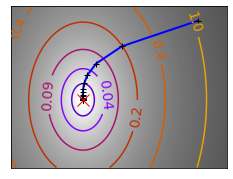

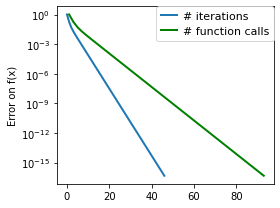

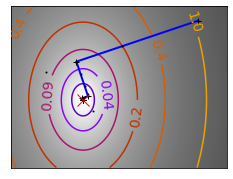

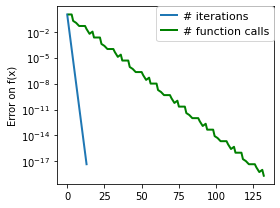

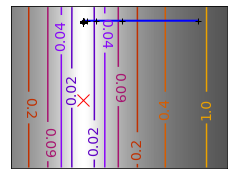

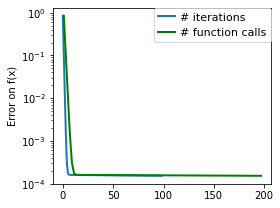

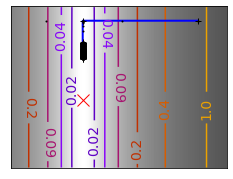

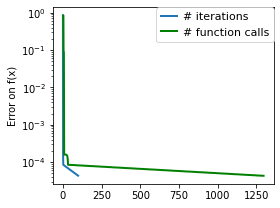

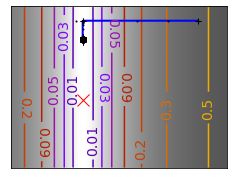

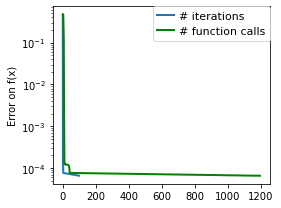

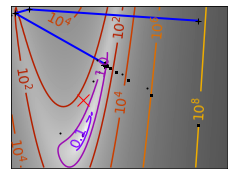

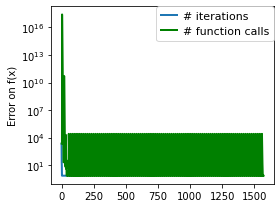

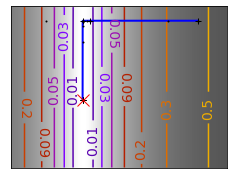

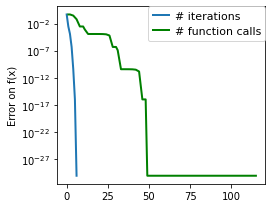

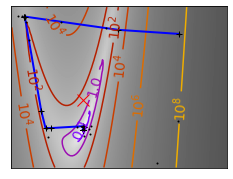

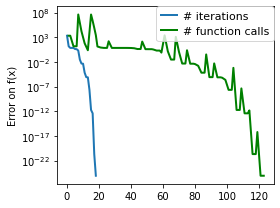

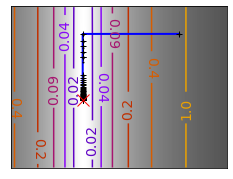

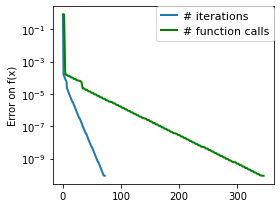

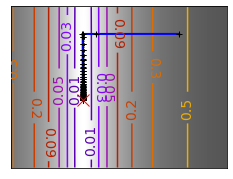

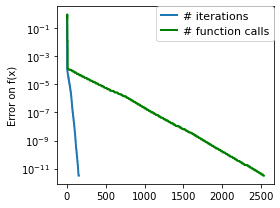

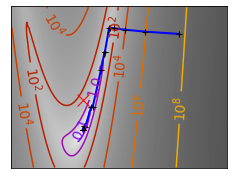

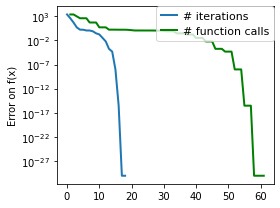

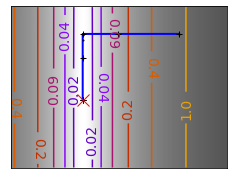

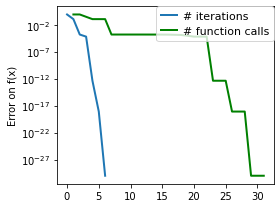

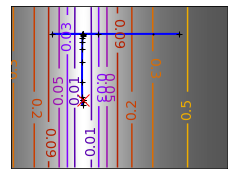

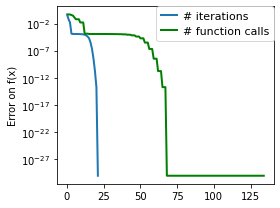

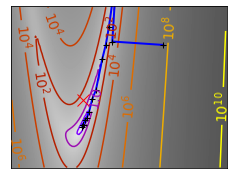

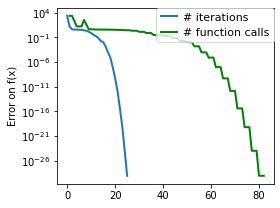

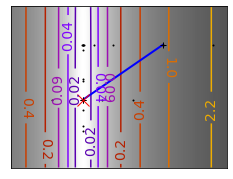

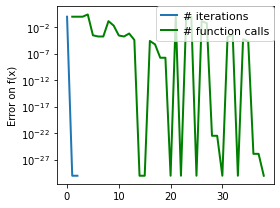

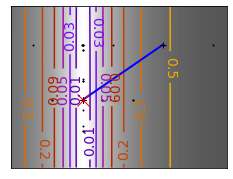

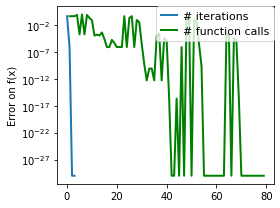

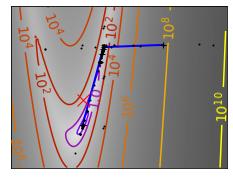

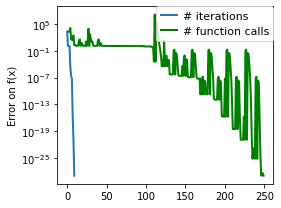

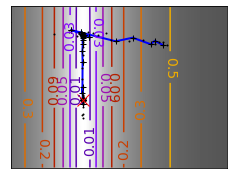

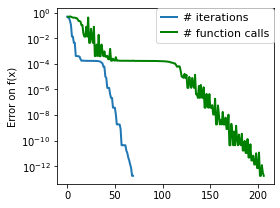

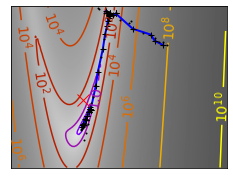

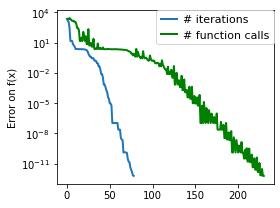

In [19]:
levels = dict()

for index, ((f, f_prime, hessian), optimizer) in enumerate((
                (mk_quad(.7), gradient_descent),
                (mk_quad(.7), gradient_descent_adaptative),
                (mk_quad(.02), gradient_descent),
                (mk_quad(.02), gradient_descent_adaptative),
                (mk_gauss(.02), gradient_descent_adaptative),
                ((rosenbrock, rosenbrock_prime, rosenbrock_hessian),
                                    gradient_descent_adaptative),
                (mk_gauss(.02), conjugate_gradient),
                ((rosenbrock, rosenbrock_prime, rosenbrock_hessian),
                                    conjugate_gradient),
                (mk_quad(.02), newton_cg),
                (mk_gauss(.02), newton_cg),
                ((rosenbrock, rosenbrock_prime, rosenbrock_hessian),
                                    newton_cg),
                (mk_quad(.02), bfgs),
                (mk_gauss(.02), bfgs),
                ((rosenbrock, rosenbrock_prime, rosenbrock_hessian),
                            bfgs),
                (mk_quad(.02), powell),
                (mk_gauss(.02), powell),
                ((rosenbrock, rosenbrock_prime, rosenbrock_hessian),
                            powell),
                (mk_gauss(.02), nelder_mead),
                ((rosenbrock, rosenbrock_prime, rosenbrock_hessian),
                            nelder_mead),
            )):

    # Compute a gradient-descent
    x_i, y_i = 1.6, 1.1
    counting_f_prime = CountingFunction(f_prime)
    counting_hessian = CountingFunction(hessian)
    logging_f = LoggingFunction(f, counter=counting_f_prime.counter)
    all_x_i, all_y_i, all_f_i = optimizer(np.array([x_i, y_i]),
                                          logging_f, counting_f_prime,
                                          hessian=counting_hessian)

    # Plot the contour plot
    if not max(all_y_i) < y_max:
        x_min *= 1.2
        x_max *= 1.2
        y_min *= 1.2
        y_max *= 1.2
    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    x = x.T
    y = y.T

    plt.figure(index, figsize=(3, 2.5))
    plt.clf()
    plt.axes([0, 0, 1, 1])

    X = np.concatenate((x[np.newaxis, ...], y[np.newaxis, ...]), axis=0)
    z = np.apply_along_axis(f, 0, X)
    log_z = np.log(z + .01)
    plt.imshow(log_z,
            extent=[x_min, x_max, y_min, y_max],
            cmap=plt.cm.gray_r, origin='lower',
            vmax=log_z.min() + 1.5*log_z.ptp())
    contours = plt.contour(log_z,
                        levels=levels.get(f, None),
                        extent=[x_min, x_max, y_min, y_max],
                        cmap=plt.cm.gnuplot, origin='lower')
    levels[f] = contours.levels
    plt.clabel(contours, inline=1,
                fmt=super_fmt, fontsize=14)

    plt.plot(all_x_i, all_y_i, 'b-', linewidth=2)
    plt.plot(all_x_i, all_y_i, 'k+')

    plt.plot(logging_f.all_x_i, logging_f.all_y_i, 'k.', markersize=2)

    plt.plot([0], [0], 'rx', markersize=12)


    plt.xticks(())
    plt.yticks(())
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.draw()

    plt.figure(index + 100, figsize=(4, 3))
    plt.clf()
    plt.semilogy(np.maximum(np.abs(all_f_i), 1e-30), linewidth=2,
                label='# iterations')
    plt.ylabel('Error on f(x)')
    plt.semilogy(logging_f.counts,
                np.maximum(np.abs(logging_f.all_f_i), 1e-30),
                linewidth=2, color='g', label='# function calls')
    plt.legend(loc='upper right', frameon=True, prop=dict(size=11),
              borderaxespad=0, handlelength=1.5, handletextpad=.5)
    plt.tight_layout()
    plt.draw()